<a href="https://colab.research.google.com/github/JALVARADORUIZ/Magister_BigData_UB/blob/main/M6_AI4_AlvaradoRuizJoseArmando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*PADAWAN*: 


##JOSE ARMANDO ALVARADO RUIZ

# **Tema 4. Algoritmos ensamblados**

**Entrega: ESTIMACIÓN DE PRECIOS DE INMUEBLES**


# **Descripción de la tarea**

###Contexto

Disponemos de un dataset con información de inmuebles vendidos en el Condado de King, incluida la ciudad de Seattle, entre mayo de 2014 y mayo de 2015.

El objetivo de la práctica consiste en utilizar dos de los algoritmos vistos en el módulo para la estimación de los precios de venta de inmuebles en este condado y para esas fechas.

Las variables son las siguientes: 

- Id: identificador del inmueble. 
- Date: fecha de venta en formato “YYYYMMDDT000000”. 
- Price: precio de venta final en $. 
- Bedrooms: número de habitaciones del inmueble. 
- Bathrooms: número de aseos del inmueble. 
- Sqft_living: área del inmueble en pies cuadrados. 
- Sqft_lot: área de la parcela en la que se encuentra. 
- Floors: número de pisos del inmueble. 
- Waterfront: valor = 0 si no tiene vistas al mar; valor = 1 si tiene vistas al mar. 
- View: nos dice si ha sido visitada por potenciales compradores muchas o pocas veces (0 pocas, 4 muchas). 
- Condition: condición en la que se encuentra el inmueble (1 mal, 5 muy bien). 
- Grade: calificación dada al inmueble, basada en un sistema propio del Condado de King (cuanto mayor es el valor, mejor es el inmueble). 
- Sqft_above: área en pies cuadrados del inmueble si no contamos el sótano. 
- Sqft_basement: área en pies cuadrados del sótano. 
- Yr_built: año de construcción. 
- Yr_renovated: año en que fue reformado/restaurado. 
- Zipcode: parecido al código postal español. 
- Lat: latitud en grados. 
- Lon: longitud en grados. 
- Sqft_living15: área media de los 15 inmuebles vecinos más cercanos. 
- Sqft_lot15: área media de las 15 parcelas vecinas más cercanas.

### **Importación librerias**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree  import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from scipy.stats import pearsonr
import graphviz
import warnings
from time import time
import datetime
import random


%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


def segundos_a_minutos(segundos):
    horas = int(segundos / 60 / 60)
    segundos -= horas*60*60
    minutos = int(segundos/60)
    segundos -= minutos*60
    return f"{horas:02d}:{minutos:02d}:{segundos:02d}"

# Lectura del dataset. 

In [2]:
# Apertura del dataset ubicado en mi github para un rápido acceos
url_file = "https://raw.githubusercontent.com/JALVARADORUIZ/Magister_BigData_UB/main/act4_kc_house_data.csv"
df = pd.read_csv(url_file)

# Visualización de los primeros 5 registros:
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
# Eliminamos la columna id (solo identificativa)

df.drop('id', axis = 1, inplace = True)

# Análisis de los Datos

Antes de comenzar con el modelado, vamos a realizar un analisis y consistencia de los datos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

In [5]:
# Tamaño del DataSet
df.shape

(21613, 20)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.141767,367127.196483,75000.0000,321950.000,450000.0000,645000.000,7.700000e+06
bedrooms,21613.0,3.370842,0.930062,0.0000,3.000,3.0000,4.000,3.300000e+01
bathrooms,21613.0,2.114757,0.770163,0.0000,1.750,2.2500,2.500,8.000000e+00
sqft_living,21613.0,2079.899736,918.440897,290.0000,1427.000,1910.0000,2550.000,1.354000e+04
sqft_lot,21613.0,15106.967566,41420.511515,520.0000,5040.000,7618.0000,10688.000,1.651359e+06
floors,21613.0,1.494309,0.539989,1.0000,1.000,1.5000,2.000,3.500000e+00
waterfront,21613.0,0.007542,0.086517,0.0000,0.000,0.0000,0.000,1.000000e+00
view,21613.0,0.234303,0.766318,0.0000,0.000,0.0000,0.000,4.000000e+00
condition,21613.0,3.409430,0.650743,1.0000,3.000,3.0000,4.000,5.000000e+00
grade,21613.0,7.656873,1.175459,1.0000,7.000,7.0000,8.000,1.300000e+01


De acuerdo a la información del dataset podemos determinar que:

* El dataset cuenta con 21613 registros con 20 variables. 
* No se cuenta con valores nulos en los registros. 
* La variable date es del tipo object, las demás númericas.
* Existen algunas inconsistencias en los tipos de variables como por ejemplo bathrooms y floors que estan como float, lo cual no podría ser. Se debe determinar como afrontarlo.
* Se tienen varis variables categoricas, pero que son ordinales, por lo que no se requiere de una transformación del tipo dummies. Además ya estas variables se encuentran en formato númerico. Las variables de este tipo son: Grade, Condition, View.
* Waterfront es una variable binaria, tampoco requiere de una transformación del tipo dummies.

# Preprocesado de Datos

Vamos a proceder a realizar algunas transformaciones a los datos para generar modelos más robustos.

## Convertir las áreas a metros cuadrados. 

Como estamos trabajando en países de habla hispana, trabajaremos con metros cuadrados en vez de pies cuadrados. Se debe realizar conversion para cada una de las variables asociadas a dichas medidas.

In [7]:
variables = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']

# formula para convertiro: m² =ft²/10,764
for var in variables:
  df[var] = df[var]/10.764

In [8]:
# Cambiamos nombre de variables para identificar de forma correcta:
df.rename(columns={'sqft_living':'sqmt_living',
                   'sqft_lot':'sqmt_lot',
                   'sqft_above':'sqmt_above',
                   'sqft_basement':'sqmt_basement',
                   'sqft_living15':'sqmt_living15',
                   'sqft_lot15':'sqmt_lot15'
                   },
               inplace=True)

## Convertir la fecha de venta “YYYYMMDD”

Originalmente la variable date es del tipo object, la vamos a convertir a formato date.

In [9]:
# Convertimos a formato datetime
df["date"] = pd.to_datetime(df['date'])

## Transformación de Variables

Como se indico en la primera sección, las variables bathrooms y floors son del tipo float siendo que deben ser enteros. Vamos a asumir que son valores enteros para generar un modelo más conciso.

In [10]:
df["bathrooms"].value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

Existe un problema ya que no existe en el mercado por ejemplo 0.75 bathroom (0.75 baños).

In [11]:
df["floors"].value_counts()

1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

En floors pasa algo similar, aunque es un poco más entendible en ciertos casos, pero asumir eso no esta dentro de nuestro conocimiento, por lo que en ambos casos vamos a asumir y transformar a valores enteros.

In [12]:
df["bedrooms"] = df["bedrooms"].astype(int)
df["floors"] = df["floors"].astype(int)

La variable "yr_renovated" aunque es un entero, podemos mapearla en 1 o 0 solo con el hecho de si ha sido renovada o no.

In [13]:
# Valores asociados de variable yr_renovated
df["yr_renovated"].value_counts()

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

Se puede ver que existen 20699 registros (más del 95%) no han sido renovadas. Crearemos una nueva variable "renovated" con 0 (si no hay arreglo) o 1 (si hay arreglo).

In [14]:
df["renovated"] = df["yr_renovated"].apply(lambda x:0 if x==0 else 1)

La variable "yr_built" esta asociada a un año, el cual se puede asociar al año de venta de la casa y determinar la antiguedad de la casa. Asi podemos dejar de prescindir de estas variables construyendo "old_house".

In [15]:
df["old_house"] = df["date"].dt.strftime('%Y').astype(int) - df["yr_built"]

Ahora eliminamos las columnas que  fueron transformadas por las nuevas columnas:

In [16]:
drop_columns = ["date","yr_built","yr_renovated"]
df.drop(drop_columns, axis=1, inplace=True)

In [17]:
df.head(5)

,price,bedrooms,bathrooms,sqmt_living,sqmt_lot,floors,waterfront,view,condition,grade,sqmt_above,sqmt_basement,zipcode,lat,long,sqmt_living15,sqmt_lot15,renovated,old_house
0,221900.0,3,1.00,109.624675,524.897808,1,0,0,3,7,109.624675,0.000000,98178,47.5112,-122.257,124.489038,524.897808,0,59
1,538000.0,3,2.25,238.758826,672.798216,2,0,0,3,7,201.597919,37.160907,98125,47.7210,-122.319,157.004831,709.680416,1,63
2,180000.0,2,1.00,71.534745,929.022668,1,0,0,3,6,71.534745,0.000000,98028,47.7379,-122.233,252.694166,748.978075,0,82
3,604000.0,4,3.00,182.088443,464.511334,1,0,0,5,7,97.547380,84.541063,98136,47.5208,-122.393,126.347083,464.511334,0,49
4,510000.0,3,2.00,156.075808,750.650316,1,0,0,3,8,156.075808,0.000000,98074,47.6168,-122.045,167.224080,697.045708,0,28


## Correlación Variable Price

Ahora vamos a ver la correlación de "price" con otras variables para ver cuántas variables están fuertemente correlacionadas con nuestra variable target.

In [18]:
# Seleccionamos las variables target y features
features = df.iloc[:,1:].columns.tolist()
target = df.iloc[:,0].name

In [19]:
target, features

('price',
 ['bedrooms',
  'bathrooms',
  'sqmt_living',
  'sqmt_lot',
  'floors',
  'waterfront',
  'view',
  'condition',
  'grade',
  'sqmt_above',
  'sqmt_basement',
  'zipcode',
  'lat',
  'long',
  'sqmt_living15',
  'sqmt_lot15',
  'renovated',
  'old_house'])

In [20]:
# buscamos las correlaciones de cada variable con price
correlations = {}
for f in features:
    df_temp = df[[f,target]]
    x1 = df_temp[f].values
    x2 = df_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [21]:
# Correlacion de variables con respecto a price ordenadas de mayor a menor.
df_correlations = pd.DataFrame(correlations, index=['Value']).T
df_correlations.loc[df_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqmt_living vs price,0.702035
grade vs price,0.667434
sqmt_above vs price,0.605567
sqmt_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqmt_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


Podemos ver que existen a lo menos 5 de las variables correlacionadas en forma importante y positivamente a price, mientras que old_house y zip_code se correlacionan en forma negativa, por lo que estas variables la descartaremos de la predicción del precio de vivienda.

In [22]:
df.drop(["old_house","zipcode"], axis=1, inplace = True)

# Visualización de Principales Variables vs Price

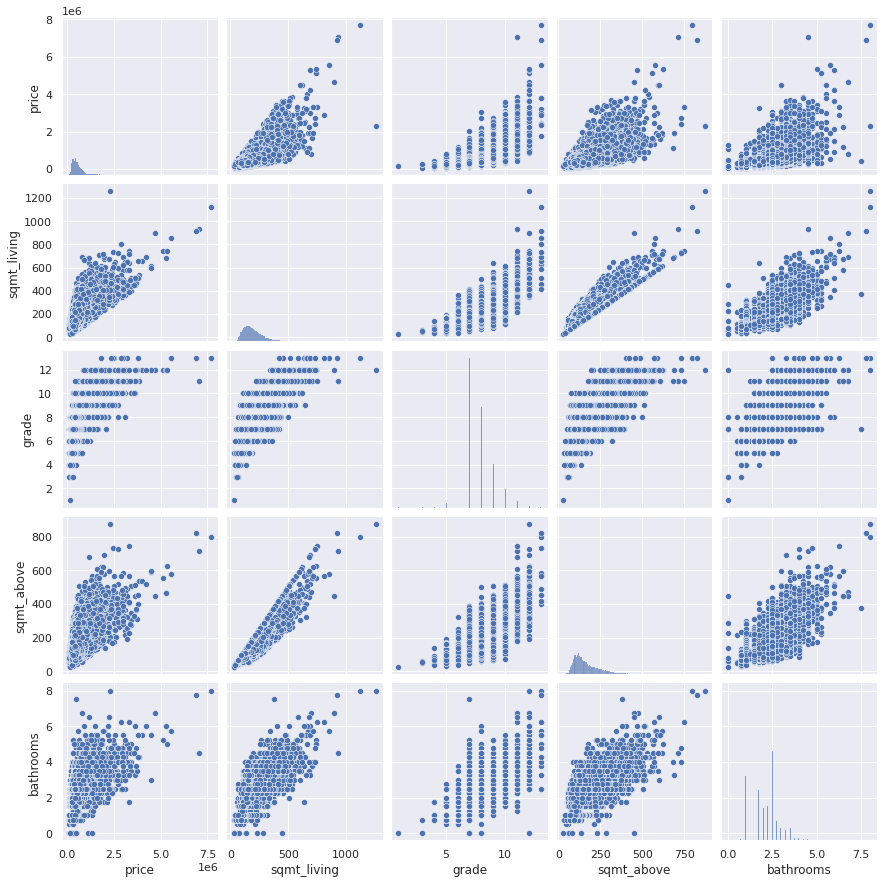

In [23]:
#Pairplots para visualizar las correlaciones 
sns.set()
cols = ['price', 'sqmt_living', 'grade', 'sqmt_above', 'bathrooms']
sns.pairplot(df[cols], height = 2.5)
plt.show();

Podemos ver la distribución de la variable price, donde se observa asimetria positiva con una larga cola hacia la izquierda, demostrando que existe valores de viviendas muy elevadas a la media. 

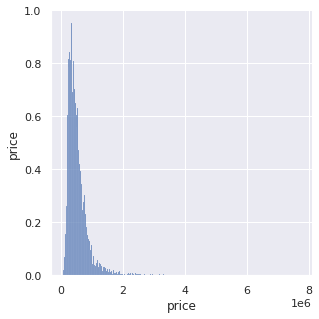

In [24]:
sns.pairplot(df[["price"]], height = 4.5)
plt.show();

Acá será adecuado transformar la variable price y escalarla a logaritmo.

In [25]:
df["log_price"] = np.log(df["price"])

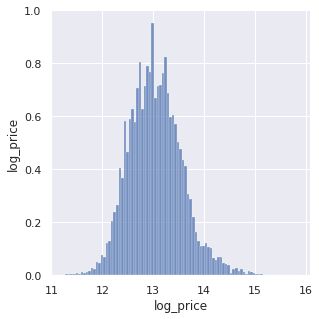

In [26]:
sns.pairplot(df[["log_price"]], height = 4.5)
plt.show();

Vemos una distribución con tendencia a normal, por lo que utilizaremos como variable target log_price, y eliminaremos la variable price.

In [27]:
df.drop(['price'], axis=1, inplace=True)

# Estimación de precios

Teniendo definido nuestro dataset, vamos a proceder a crear los modelos solicitados.

In [28]:
# Definicion de la variables predictoras (y) y el target (X)

y = df[["log_price"]].values
X = df.iloc[:,:-1].values

In [29]:
# Separamos los datos de train y test (otrogamos 70% para train y 30% para test).

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15129, 16), (6484, 16), (15129, 1), (6484, 1))

## Utilizar el algoritmo de Árboles de Decisión

Utilizaremos RandomzedSearchCV para probar los 3 modelos, esto ya que nos permite además encontrar los mejores parametros para un modelo más preciso. Utilizaremos el Árbol de decisión como base de las metricas, siendo los modelos de RandomForest y GradientBoosting los modelos que deberían entregarnos los mejores resultados.

In [170]:
# Definición de parametros:
# El número de características a tener en cuenta al buscar la mejor división
# Se definen un mínimo de profundidad del árbol de 2 y un máximo de 21. Se analizarán con los 3 criterios que se señalan en max_features.

max_features = ['auto', 'sqrt', 'log2']

param_grid = {'max_depth': sp_randInt(2, 21),
              'max_features': max_features
             }

In [171]:
dt_RandomGrid = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state = 0), 
                                   scoring    = 'neg_mean_squared_error', #'accuracy'
                                   return_train_score = True,
                                   param_distributions = param_grid, 
                                   cv = KFold(n_splits=10, random_state=123, shuffle=True), 
                                   verbose = 2, 
                                   n_jobs = -1, 
                                   random_state = 0)


In [172]:
start = time()
dt_RandomGrid.fit(x_train, y_train)
end = time()
tiempo_dt = segundos_a_minutos(int(end - start))

print("Tiempo de entrenamiento:", tiempo_dt)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Tiempo de entrenamiento: 00:00:06


In [173]:
dt_RandomGrid.best_params_

{'max_depth': 11, 'max_features': 'auto'}

Los mejores parámetros para nuestro modelo de Arbol de Decisión fueron un max_depth de 11 y utilizando max_features = auto.

In [174]:
dt_RandomGrid.best_score_

-0.05069414252970121

El mejor score asociado al modelo fue de 0.05 (mean_squared_error)

In [175]:
#Generamos el modelo con los mejores estimadores:
model_dt = dt_RandomGrid.best_estimator_

Vemos la importancia de cada una de las variables en nuestro modelo.

In [222]:
dt_features_analitics = pd.DataFrame({"Feature": df.iloc[:,:-1].columns,
                                      "Importance":model_dt.feature_importances_})
dt_features_analitics.sort_values(by='Importance', ascending=False)

,Feature,Importance
8,grade,0.370655
11,lat,0.318878
2,sqmt_living,0.178881
12,long,0.052351
13,sqmt_living15,0.022944
6,view,0.011088
9,sqmt_above,0.010628
14,sqmt_lot15,0.009453
3,sqmt_lot,0.009267
5,waterfront,0.006654


In [176]:
accuracy_train_dt = round(model_dt.score(x_train,y_train),5)
accuracy_test_dt = round(model_dt.score(x_test,y_test),5)

print(f'Train Accuracy : {accuracy_train_dt}')
print(f'Test Accuracy  : {accuracy_test_dt}')

Train Accuracy : 0.91892
Test Accuracy  : 0.83028


In [177]:
predict_dt = model_dt.predict(x_test)

Obtenemos la predicción de los datos Test, recordemos que nu7estro valor estimado es log_price, por lo que debemos realizar la transformación con exponencial.

In [178]:
compare_model_dt = pd.DataFrame({'test_data_log' : y_test[:,-1], 
                                'prediction_data_log': predict_dt
                              })
compare_model_dt.head(10)

,test_data_log,prediction_data_log
0,13.185338,13.471825
1,12.923912,13.210251
2,13.570249,13.700581
3,13.810498,13.862070
4,12.538967,12.529967
5,12.072541,12.262801
6,13.442997,13.322776
7,12.524526,12.897755
8,13.049793,13.048702
9,13.134292,13.031104


Predicción Test en valores $:

In [179]:
compare_model_dt["test_data_$"] = compare_model_dt["test_data_log"].apply(lambda x:np.exp(x))
compare_model_dt["prediction_data_$"] = round(compare_model_dt["prediction_data_log"].apply(lambda x:np.exp(x)),1)
compare_model_dt["diferencia_$"] = compare_model_dt["test_data_$"] - compare_model_dt["prediction_data_$"]
compare_model_dt["diferencia_%"] = round(((compare_model_dt["test_data_$"] / compare_model_dt["prediction_data_$"])*100)-100,1)
compare_model_dt.head(10)

,test_data_log,prediction_data_log,test_data_$,prediction_data_$,diferencia_$,diferencia_%
0,13.185338,13.471825,532500.0,709151.6,-176651.6,-24.9
1,12.923912,13.210251,410000.0,545932.8,-135932.8,-24.9
2,13.570249,13.700581,782500.0,891428.8,-108928.8,-12.2
3,13.810498,13.862070,995000.0,1047660.7,-52660.7,-5.0
4,12.538967,12.529967,279000.0,276500.2,2499.8,0.9
5,12.072541,12.262801,175000.0,211673.7,-36673.7,-17.3
6,13.442997,13.322776,689000.0,610953.4,78046.6,12.8
7,12.524526,12.897755,275000.0,399414.5,-124414.5,-31.1
8,13.049793,13.048702,465000.0,464493.1,506.9,0.1
9,13.134292,13.031104,506000.0,456390.5,49609.5,10.9


## Utilizar el algoritmo de Random Forest. 

In [180]:
# Definición de parametros a buscar para RandomForest
# El número de características a tener en cuenta al buscar la mejor división
max_features = ['auto', 'sqrt', 'log2']

param_grid = {'max_features': max_features,
              'n_estimators' : sp_randInt(100, 500), # Se buscaran entre 100 a 500 estimadores.
              'max_depth'    : sp_randInt(2, 21) # Profundidad a utilizar entre 2 a 21.
            }

In [181]:
rf_RandomGrid = RandomizedSearchCV(estimator = RandomForestRegressor(random_state = 0), 
                                   scoring    = 'neg_mean_squared_error', 
                                   return_train_score = True,
                                   param_distributions = param_grid, 
                                   cv = KFold(n_splits=10, random_state=123, shuffle=True), 
                                   verbose = 2, 
                                   n_jobs = -1, 
                                   random_state = 0)


In [182]:
start = time()
rf_RandomGrid.fit(x_train, y_train)
end = time()

tiempo_rf = segundos_a_minutos(int(end - start))
print("Tiempo de entrenamiento:", tiempo_rf)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Tiempo de entrenamiento: 00:18:28


In [183]:
rf_RandomGrid.best_params_

{'max_depth': 17, 'max_features': 'auto', 'n_estimators': 438}

Los mejores parametros se encontraron con max_dept = 17, max_features = auto y numero de estimadores de 438.

In [184]:
# Definición del modelo RandomForest con los mejores parametros:
model_rf = rf_RandomGrid.best_estimator_

In [185]:
rf_RandomGrid.best_score_

-0.032132056276215404

Se obtiene un menor mean_squared_error que en el Árbol de decisión, esta vez un 0.03 contra un 0.05.

Se determinan las variables más importantes en el modelo RandomForest.

In [223]:
rf_features_analitics = pd.DataFrame({"Feature": df.iloc[:,:-1].columns,
                                      "Importance":model_rf.feature_importances_})
rf_features_analitics.sort_values(by='Importance', ascending=False)


,Feature,Importance
8,grade,0.322944
11,lat,0.307386
2,sqmt_living,0.195812
12,long,0.055679
13,sqmt_living15,0.029455
3,sqmt_lot,0.018737
14,sqmt_lot15,0.016304
9,sqmt_above,0.015985
6,view,0.010496
7,condition,0.006352


In [186]:
accuracy_train_rf = round(model_rf.score(x_train,y_train),5)
accuracy_test_rf = round(model_rf.score(x_test,y_test),5)

print(f'Train Accuracy : {accuracy_train_rf}')
print(f'Test Accuracy  : {accuracy_test_rf}')

Train Accuracy : 0.97665
Test Accuracy  : 0.89038


In [187]:
predict_rf = model_rf.predict(x_test)

In [188]:
compare_model_rf = pd.DataFrame({'test_data_log' : y_test[:,-1], 
                                'prediction_data_log': predict_rf
                              })
compare_model_rf.head(10)

,test_data_log,prediction_data_log
0,13.185338,13.398067
1,12.923912,13.185819
2,13.570249,13.704581
3,13.810498,13.837184
4,12.538967,12.548720
5,12.072541,12.299573
6,13.442997,13.328217
7,12.524526,12.940493
8,13.049793,12.985774
9,13.134292,13.042295


Predicion de Test en modelo RandomForest.

In [189]:
compare_model_rf["test_data_$"] = compare_model_rf["test_data_log"].apply(lambda x:np.exp(x))
compare_model_rf["prediction_data_$"] = round(compare_model_rf["prediction_data_log"].apply(lambda x:np.exp(x)),1)
compare_model_rf["diferencia_$"] = compare_model_rf["test_data_$"] - compare_model_rf["prediction_data_$"]
compare_model_rf["diferencia_%"] = round(((compare_model_rf["test_data_$"] / compare_model_rf["prediction_data_$"])*100)-100,1)
compare_model_rf.sample(10)

,test_data_log,prediction_data_log,test_data_$,prediction_data_$,diferencia_$,diferencia_%
282,13.058358,13.217669,469000.0,549997.6,-80997.6,-14.7
498,13.235603,13.165000,559950.0,521779.4,38170.6,7.3
4879,14.217637,14.083781,1495000.0,1307700.7,187299.3,14.3
1968,13.047640,13.032655,464000.0,457098.9,6901.1,1.5
6102,12.947998,12.915799,419995.0,406687.0,13308.0,3.3
3888,12.793859,12.776029,360000.0,353637.9,6362.1,1.8
482,13.993657,14.145015,1195000.0,1390278.3,-195278.3,-14.0
3049,12.915708,12.892451,406650.0,397301.7,9348.3,2.4
1702,12.736701,12.792564,340000.0,359533.9,-19533.9,-5.4
181,13.614618,13.819082,818000.0,1003578.2,-185578.2,-18.5


## Utilizar el algoritmo de Grandient Boosting.

In [190]:
# Parametros a utilizar en Grandient Boosting
# El número de características a tener en cuenta al buscar la mejor división
max_features = ['auto', 'sqrt', 'log2']

# Tasa de Aprendizaje. Se determinan 4 valores a utilizar en learning_rate (valores pequeños para evitar overfitting)
learning_rate = [0.0001, 0.001, 0.01, 0.1] 

# Funcion Loss para ser optimizado.
loss = ['squared_error', 'absolute_error'] 

param_grid = {'learning_rate': learning_rate,
              'max_features': max_features,
              'n_estimators' : sp_randInt(100, 500), # Se buscaran estimadores de 100 a 500
              'max_depth'    : sp_randInt(2, 21), # Profundidad a utilizar entre 2 a 21.
              'loss': loss 
             }

In [191]:
gb_RandomGrid = RandomizedSearchCV(estimator = GradientBoostingRegressor(random_state = 0), 
                                   scoring    = 'neg_mean_squared_error', 
                                   return_train_score = True,
                                   param_distributions = param_grid, 
                                   cv = KFold(n_splits=10, random_state=123, shuffle=True), 
                                   verbose = 2, 
                                   n_jobs = -1, 
                                   random_state = 0)

In [192]:
start = time()
gb_RandomGrid.fit(x_train, y_train)
end = time()

tiempo_gb = segundos_a_minutos(int(end - start))
print("Tiempo de entrenamiento:", tiempo_gb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Tiempo de entrenamiento: 00:35:29


Mejores parámetros para el Modelo generado con GradientBoosting:

In [193]:
gb_RandomGrid.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 16,
 'max_features': 'auto',
 'n_estimators': 365}

Veamos que el n_estimators fue de 365, este es el número de etapas de refuerzo a realizar. El aumento de gradiente es bastante resistente al sobreajuste, por lo que un gran número generalmente da como resultado un mejor rendimiento.

In [194]:
# Generamos modelo con los mejores estimadores:
model_gb = gb_RandomGrid.best_estimator_

Podemos apreciar que el mean_squared_error es menor en este modelo que en el los dos modelos anteriores:

In [195]:
gb_RandomGrid.best_score_

-0.031413771390288614

Determinación de la importancia de las variables en el modelo:

In [224]:
gb_features_analitics = pd.DataFrame({"Feature": df.iloc[:,:-1].columns,
                                      "Importance":model_gb.feature_importances_})
gb_features_analitics.sort_values(by='Importance', ascending=False)

,Feature,Importance
11,lat,0.182663
2,sqmt_living,0.118203
12,long,0.114815
3,sqmt_lot,0.112655
14,sqmt_lot15,0.106162
13,sqmt_living15,0.104390
9,sqmt_above,0.081872
10,sqmt_basement,0.044373
1,bathrooms,0.039470
8,grade,0.027793


In [196]:
accuracy_train_gb = round(model_gb.score(x_train,y_train),5)
accuracy_test_gb = round(model_gb.score(x_test,y_test),5)

print(f'Train Accuracy : {accuracy_train_gb}')
print(f'Test Accuracy  : {accuracy_test_gb}')

Train Accuracy : 0.98955
Test Accuracy  : 0.89094


In [197]:
predict_gb = model_gb.predict(x_test)

In [198]:
compare_model_gb = pd.DataFrame({'test_data_log' : y_test[:,-1], 
                                'prediction_data_log': predict_gb
                              })
compare_model_gb.head(10)

,test_data_log,prediction_data_log
0,13.185338,13.300942
1,12.923912,13.172962
2,13.570249,13.708692
3,13.810498,13.782070
4,12.538967,12.600526
5,12.072541,12.173874
6,13.442997,13.293802
7,12.524526,12.936529
8,13.049793,13.005126
9,13.134292,12.900642


Predicción en Data Test para el modelo GradientBoosting:

In [199]:
compare_model_gb["test_data_$"] = compare_model_gb["test_data_log"].apply(lambda x:np.exp(x))
compare_model_gb["prediction_data_$"] = round(compare_model_gb["prediction_data_log"].apply(lambda x:np.exp(x)),1)
compare_model_gb["diferencia_$"] = compare_model_gb["test_data_$"] - compare_model_gb["prediction_data_$"]
compare_model_gb["diferencia_%"] = round(((compare_model_gb["test_data_$"] / compare_model_gb["prediction_data_$"])*100)-100,1)
compare_model_gb.sample(10)

,test_data_log,prediction_data_log,test_data_$,prediction_data_$,diferencia_$,diferencia_%
2698,12.751300,12.988833,345000.0,437500.3,-92500.3,-21.1
2536,13.683017,13.600993,875909.0,806930.3,68978.7,8.5
3401,13.669328,13.732149,864000.0,920018.4,-56018.4,-6.1
5008,13.795002,13.632852,979700.0,833052.6,146647.4,17.6
431,12.925131,12.925667,410500.0,410719.8,-219.8,-0.1
216,12.254625,12.581257,209950.0,291052.0,-81102.0,-27.9
6241,12.882836,12.913791,393500.0,405871.2,-12371.2,-3.0
3087,13.017003,13.006941,450000.0,445494.7,4505.3,1.0
321,12.594731,12.903403,295000.0,401676.8,-106676.8,-26.6
816,13.195614,13.229704,538000.0,556656.9,-18656.9,-3.4


# Evaluación de los modelos

Obtenemos varias metricas de los tres modelos creados:

In [225]:
# Determinación de R2 para cada modelo:
r2_dt = r2_score(y_test[:,-1], predict_dt)
r2_rf = r2_score(y_test[:,-1], predict_rf)
r2_gb = r2_score(y_test[:,-1], predict_gb)

In [203]:
# Determinación de la varianza explicada
variance_dt = explained_variance_score(predict_dt,y_test[:,-1])
variance_rf = explained_variance_score(predict_rf,y_test[:,-1])
variance_gb = explained_variance_score(predict_gb,y_test[:,-1])

In [205]:
# Comparación de modelos sobre la base de r2 y otras metricas
models_analitics = pd.DataFrame({
    'Model': ['Decision Tree','Random Forest','Gradient Boosting'],
    'Accuracy Train': [accuracy_train_dt,accuracy_train_rf,accuracy_train_gb],
    'Accuracy Test': [accuracy_test_dt,accuracy_test_rf,accuracy_test_gb],
    'Mean Square Error':[round(dt_RandomGrid.best_score_,5),round(rf_RandomGrid.best_score_,5),round(gb_RandomGrid.best_score_,5)],
    'R2': [r2_dt,r2_rf,r2_gb],
    'Explained Variance Score': [variance_dt,variance_rf,variance_gb],
    'Tiempo de entrenamiento': [tiempo_dt,tiempo_rf,tiempo_gb]
    })
    
models_analitics.sort_values(by='R2', ascending=False)

,Model,Accuracy Train,Accuracy Test,Mean Square Error,R2,Explained Variance Score,Tiempo de entrenamiento
2,Gradient Boosting,0.98955,0.89094,-0.03141,0.890942,0.872808,00:35:29
1,Random Forest,0.97665,0.89038,-0.03213,0.890380,0.873931,00:18:28
0,Decision Tree,0.91892,0.83028,-0.05069,0.830276,0.813377,00:00:06


Podemos visualizar en este dataframe con las metricas, que el modelo GradientBoosting presenta un mejor R2, aunque muy similar a RandomForest.
 Con respecto a la La puntuación de la varianza explicada es similar a la puntuación R^2, con la notable diferencia de que no tiene en cuenta las compensaciones sistemáticas en la predicción. La mayoría de las veces se debe preferir la puntuación R^2.

Con respecto a Accuracy el modelo GradientBoosting presenta mejores valores tanto en train como en test, la diferencia tambien puede considerar que en el modelo GradientBoosting considera el parámetro learning_rate que busca evitar con valores pequeños el overfitting en el modelo.

En consecuencia, hemos visto que el acuracy del modelo GradientBoosting es de alrededor del 89,094% y también logró una puntuación de R2 de 0,8909, que está muy cerca de 1. Por lo tanto, se infiere que Gradient Boosting es el modelo adecuado para este conjunto de datos.

Además, también podemos indicar que la optimización del modelo mediante el uso de RandomzedSearchCV para encontrar los parámetros apropiados nos permitio aumentar la precisión (accuracy) mediante el ajuste fino de los hiperparámetros.